In [ ]:
#Use this when working on BlackAdder:
data_path = '/media/james/tbhdd/Google Drive/'

#Use this when working on laptop:
#data_path = '/home/james/ledermau@gmail.com/EarthEngine/'

output_path = '/media/james/tbhdd/cornacle/output/'

In [ ]:
#import bqplot
import datetime
import ee
import folium
import glob
import matplotlib.pyplot as plt
import numba as nb
import numpy as np
import os
import pandas as pd
import pprint
import pylab
import random
import seaborn as sns
import statsmodels.api as sm
import time

from collections import Counter
from imageio import imwrite
from IPython.display import display, IFrame, Image
from matplotlib import gridspec
from scipy.stats import normaltest, shapiro, anderson, skew
from skimage.viewer import ImageViewer
from skimage.io import imread
from sklearn.preprocessing import normalize, StandardScaler
from tqdm import tqdm, tnrange
from os import listdir

from cornacle_lib import *
#import cornacle_lib

#from matplotlib import gridspec
pp = pprint.PrettyPrinter(depth=4)
tqdm.monitor_interval = 0

# Authenticate to the Earth Engine servers.
ee.Initialize()

plt.rc('font', size= 12)
plt.rc('figure', titlesize=18)
plt.rc('axes', titlesize= 16)
plt.rc('axes', labelsize=16)
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
plt.rc('legend', fontsize=12)

In [ ]:
corn_grain = pd.read_csv('./data/corn-grain.csv')

corn_grain_2018 = corn_grain[corn_grain['YEAR'] == 2018]
corn_grain_2018 = corn_grain_2018.groupby('STATE').mean().reset_index()
corn_grain_2018[['STATE', 'YIELD_BU_ACRE']]
corn_grain_2018['STATE'] = [state[0:2] for state in corn_grain_2018['STATE']]
corn_grain_2018.shape

In [ ]:
# Corn yields distribution across U.S.

corn_grain[['YIELD_BU_ACRE']].plot.hist(bins=50, color='g')
normaltest(corn_grain[['YIELD_BU_ACRE']].values.tolist())

In [ ]:
#corn yield by year violin plot
ax = sns.violinplot(x="YEAR", y="YIELD_BU_ACRE", data=corn_grain, color = 'yellow')

In [ ]:
unique_data = sorted([list(x) for x in set(tuple(x) for x in corn_grain[['STATE_FIPS', 'COUNTY_FIPS']].values)])
unique_data[:8]

In [ ]:
fips_data = [location for location in unique_data if location not in [[46, 102], [51, 131]]] #51, 131 = All nan, 46, 102 = no results
len(fips_data)

print('There are a total of {} states with {} counties in the dataset.'.format(len(corn_grain['STATE_FIPS'].unique()), len(unique_data)))

In [ ]:
# Getting county level information and statistics
# Note that the function is designed for more than one pic --> becareful with USDA which only give 1 pic per year

target_sat = {'USDA/NASS/CDL':['cropland'],
              'MODIS/006/MYD11A2':[0,4],
              'MODIS/006/MOD09A1':[0,1,2,3,4,5,6]
        }

folders = ['USDA_CROP',
           'MODIS_TEMP',
           'MODIS_LAND'
           ]

locations = [(loc[0], loc[1]) for loc in unique_data]
dates = ['2011-1-2', '2019-7-4']
scale = 500 #meters/pixel
dates_of_images = {folder:[] for folder in folders} #initialize empty dictionary with folder names as keys

county_region = ee.FeatureCollection('ft:1S4EB6319wWW2sWQDPhDvmSBIVrD3iEmCLYB7nMM')

for folder, target in zip(folders, target_sat):

    if folder == 'USDA_CROP':
        img_collection = ee.ImageCollection(target)\
                        .filterDate(dates[0], dates[1])\
                        .select(target_sat[target]) 
    else:
        img_collection = ee.ImageCollection(target)\
                        .filterDate(dates[0], dates[1])\
                        .select(target_sat[target])\
                        .filter(ee.Filter.calendarRange(3,12,'month'))

    # append bands to each image when collected
    img = img_collection.iterate(appendBand)
    

    if folder == 'USDA_CROP':
        img = ee.Image(img).eq(1)  # only corn 
    else:
        img = ee.Image(img)

    # print basic info (bands and no. of available images)
    dates_of_images[folder] += dates_available(img_collection)
    print('\n ######################### ' + target +  ' #########################')
    print("Total Dates Available: ", len(dates_of_images[folder]))
    print("Dates available: ", dates_of_images[folder])

    collection_bands = available_bands(img_collection)
    for k, v in collection_bands.items():
        print("Band", k, "will be downloaded in", v['number_available'], "images per county. (", v['percent_available'], "%)")
    
#     if False:
#         # Getting images
#         for i, (loc1, loc2) in enumerate(locations):

#             im_name = folder + '_{:.0f}_{:.0f}'.format(loc1, loc2)
#             scale  = scale
#             crs = 'EPSG:4326'   # Coordinate Reference System

#             # filter for a county
#             region = county_region.filterMetadata('StateFips', 'equals', int(loc1))
#             region = ee.FeatureCollection(region).filterMetadata('CntyFips', 'equals', int(loc2))
#             region = ee.Feature(region.first()) # get the coordinates and other features

#             while True:
#                 try:
#                     export_image(img.clip(region), folder, im_name, scale, crs)
#                 except Exception:
#                     print(Exception)
#                     time.sleep(10)
#                     continue
#                 break
#             if (i%250 == 0) or (i == len(locations)-1):
#                 print(i)        

In [8]:
# For moisture content because the collection time is not the same as MODIS, we created a time interval (+-4 days) of the MODIS image and take median out of that
# to be incorporated with MODIS.

# creating time intervals
backward = datetime.timedelta(days=-4)
date_list = [datetime.date(int(date.split('-')[0]), int(date.split('-')[1]), int(date.split('-')[2])) + backward for date in dates_of_images['MODIS_LAND']] 
date_list += [date_list[-1] - backward]

# changing to list and string format
date_list = ['{}-{}-{}'.format(date.year, date.month, date.day) for date in date_list]
date_list = [[date_list[i], date_list[i+1]] for i in range(len(date_list)-1)]

folder = 'USDA_MOISTURE'
#dates_of_images[folder] = date_list
locations = [(loc[0], loc[1]) for loc in unique_data]
scale  = scale   # 500m = 1 pixel

#################################################################################################

county_region = ee.FeatureCollection('ft:1S4EB6319wWW2sWQDPhDvmSBIVrD3iEmCLYB7nMM')
print('Total Dates {}'.format(len(date_list)))
for i, dates in enumerate(date_list):
    
    if i == 0:
        img = ee.ImageCollection('NASA_USDA/HSL/soil_moisture')\
                        .filterDate(dates[0], dates[1]) \
                        .select([0, 1]) \
                        .filter(ee.Filter.calendarRange(3,12,'month'))\
                        .median()
    else:
        img2 = ee.ImageCollection('NASA_USDA/HSL/soil_moisture')\
                    .filterDate(dates[0], dates[1]) \
                    .select([0, 1]) \
                    .filter(ee.Filter.calendarRange(3,12,'month'))\
                    .median()
        img = img.addBands(img2)
        
print('There are {} total number of images'.format(len(img.bandNames().getInfo())))

In [9]:
#DO NOT DELETE THIS
# # Getting images
# for i, (loc1, loc2) in enumerate(locations):

#     im_name = folder + '_{:.0f}_{:.0f}'.format(loc1, loc2)
#     scale  = scale
#     crs = 'EPSG:4326'   # Coordinate Reference System

#     # filter for a county
#     region = county_region.filterMetadata('StateFips', 'equals', int(loc1))
#     region = ee.FeatureCollection(region).filterMetadata('CntyFips', 'equals', int(loc2))
#     region = ee.Feature(region.first()) # get the coordinates and other features

#     while True:
#         try:
#             export_image(img.clip(region), folder, im_name, scale, crs)
#         except Exception:
#             print(Exception)
#             time.sleep(10)
#             continue
#         break
#     if (i%500 == 0) or (i == len(locations)-1):
#         print(i)

In [10]:
# #Get specific missing images
# #folder = 'USDA_CROP'; target = 'USDA/NASS/CDL'
# folder = 'MODIS_TEMP'; target = 'MODIS/006/MYD11A2'
# #folder = 'MODIS_LAND'; target = 'MODIS/006/MOD09A1'

# loc1 = 1 #State FIPS
# loc2 = 5 #County FIPS


# county_region = ee.FeatureCollection('ft:1S4EB6319wWW2sWQDPhDvmSBIVrD3iEmCLYB7nMM')

# if folder == 'USDA_CROP':
#     img_collection = ee.ImageCollection(target)\
#                     .filterDate(dates[0], dates[1])\
#                     .select(target_sat[target]) 
# else:
#     img_collection = ee.ImageCollection(target)\
#                     .filterDate(dates[0], dates[1])\
#                     .select(target_sat[target])\
#                     .filter(ee.Filter.calendarRange(3,12,'month'))

# # append bands to each image when collected
# img = img_collection.iterate(appendBand)
# if folder == 'USDA_CROP':
#     img = ee.Image(img).eq(1)  # only corn 
# else:
#     img = ee.Image(img)

# # print basic info (bands and no. of available images)
# dates_of_images[folder] += dates_available(img_collection)
# print('\n ######################### ' + target +  ' #########################')
# print("Total Dates Available: ", len(dates_of_images[folder]))
# print("Dates available: ", dates_of_images[folder])

# collection_bands = available_bands(img_collection)
# for k, v in collection_bands.items():
#     print("Band", k, "will be downloaded in", v['number_available'],
#           "images per county. (", v['percent_available'], "%)")

# im_name = folder + '_{:.0f}_{:.0f}'.format(loc1, loc2)
# scale  = scale
# crs = 'EPSG:4326'   # Coordinate Reference System

# # filter for a county
# region = county_region.filterMetadata('StateFips', 'equals', int(loc1))
# region = ee.FeatureCollection(region).filterMetadata('CntyFips', 'equals', int(loc2))
# region = ee.Feature(region.first()) # get the coordinates and other features

# # while True:
# #     try:
# #         export_image(img.clip(region), folder, im_name, scale, crs)
# #     except Exception:
# #         print(Exception)
# #         time.sleep(10)
# #         continue
# #     break        

In [11]:
for folder in folders:
    print("Files in {}: {}".format(
                folder,
                len(listdir(os.path.join(data_path, folder))))
         )

Files in USDA_CROP: 2002
Files in MODIS_TEMP: 2002
Files in MODIS_LAND: 2002


<function matplotlib.pyplot.show(*args, **kw)>

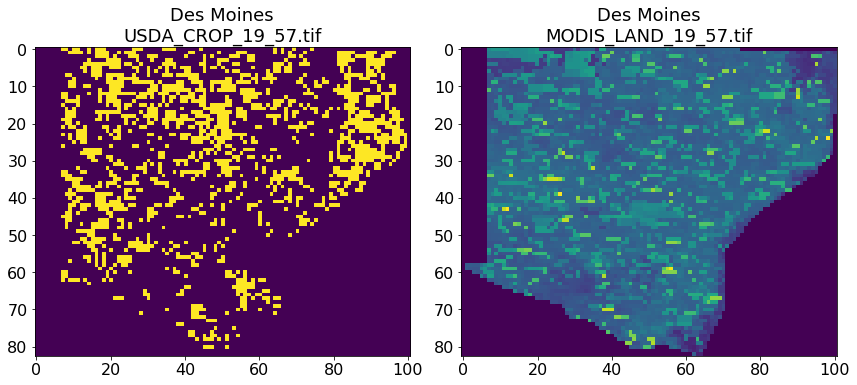

In [12]:
test_folders = ['USDA_CROP', 'MODIS_LAND']
test_county = '19_57' #des moines
test_fnames = [os.path.join(data_path, folder,
               '_'.join([folder, test_county]) + '.tif'
                           )
               for folder in test_folders]

plt.rcParams['figure.figsize'] = [12, 8]
for i, fname in enumerate(test_fnames):
    test = imread(fname)
    plt.subplot(1,2, i+1)
    plt.imshow(test[:, :, 6], )
    plt.title('Des Moines\n' + fname.split('/')[-1], fontsize=18)
    #plt.colorbar()
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
plt.savefig('Example Images', dpi=500)
plt.tight_layout(1.04)
plt.show

In [ ]:
if False: #This works
# First preprocessing stage
    path = data_path
    folders = ['USDA_CROP', 'MODIS_LAND', 'MODIS_TEMP', 'USDA_MOISTURE']
    nbands = [1, 7, 2, 2]
    

    new_dates = {}
    for state, county in tqdm(fips_data):
        # Create path
        imname_mask = folder[0] + '_' + str(state) + '_' + str(county) + '.tif'
        imname_folder_1 = folder[1] + '_' + str(state) + '_' + str(county) + '.tif' 
        imname_folder_2 = folder[2] + '_' + str(state) + '_' + str(county) + '.tif'

        # Reading figures
        mask = imread(path + folder[0] + '/' + imname_mask)
        img_1 = imread(path + folder[1] + '/' + imname_folder_1)
        img_2 = imread(path + folder[2] + '/' + imname_folder_2)

        # Lets do just 2010-2016 first
        mask, new_dates[folder[0]] = filter_year(['2011', '2018'], mask, nband[0], dates_of_images[folder[0]])
        img_1, new_dates[folder[1]] = filter_year(['2011', '2018'], img_1, nband[1], dates_of_images[folder[1]])
        img_2, new_dates[folder[2]] = filter_year(['2011', '2018'], img_2, nband[2], dates_of_images[folder[2]])

        # Making sure the bands of the figure are correct
        #if (img_1.shape[2]/nband[1] != img_2.shape[2]/nband[2]) \
        #or img_1.shape[2]/nband[1] != img_3.shape[2]/nband[3]:
        #    print(img_1.shape[2]/nband[1], img_2.shape[2]/nband[2], img_3.shape[2]/nband[3])
        #    raise ValueError('Dimension of the matrix is not correct.')

        # Split images by year
        img_1_list = split_img_by_year(img_1, nband[1], new_dates[folder[1]])
        img_2_list = split_img_by_year(img_2, nband[2], new_dates[folder[2]])

        # Masking
        for i, img_year in enumerate(img_1_list):
            for j in range(img_year.shape[2]):
                img_1_list[i][:, :, j] = img_1_list[i][:, :, j] * mask[:, :, i]
        for i, img_year in enumerate(img_2_list):
            for j in range(img_year.shape[2]):
                img_2_list[i][:, :, j] = img_2_list[i][:, :, j] * mask[:, :, i]

        year_list = list(range(2010, 2017))
        for i, img_year in enumerate(img_1_list):
            np.save(output_path + folder[1] + '//' + str(year_list[i]) + '_' + str(state) + '_' + str(county), img_year) 
        for i, img_year in enumerate(img_2_list):
            np.save(output_path + folder[2] + '//' + str(year_list[i]) + '_' + str(state) + '_' + str(county), img_year) 

In [14]:
corn_grain.head()

,Unnamed: 0,YEAR,STATE,STATE_FIPS,COUNTY,COUNTY_FIPS,ACRES_PLANTED,ACRES_HARVESTED,YIELD_BU_ACRE
0,1,2018,ALABAMA,1,AUTAUGA,1,1100,1000,165.0
1,2,2018,ALABAMA,1,DALLAS,47,5400,5100,137.3
2,3,2018,ALABAMA,1,ELMORE,51,2200,2200,170.5
3,5,2018,ALABAMA,1,PERRY,105,6400,6300,145.2
4,6,2018,ALABAMA,1,BALDWIN,3,7200,7000,152.0


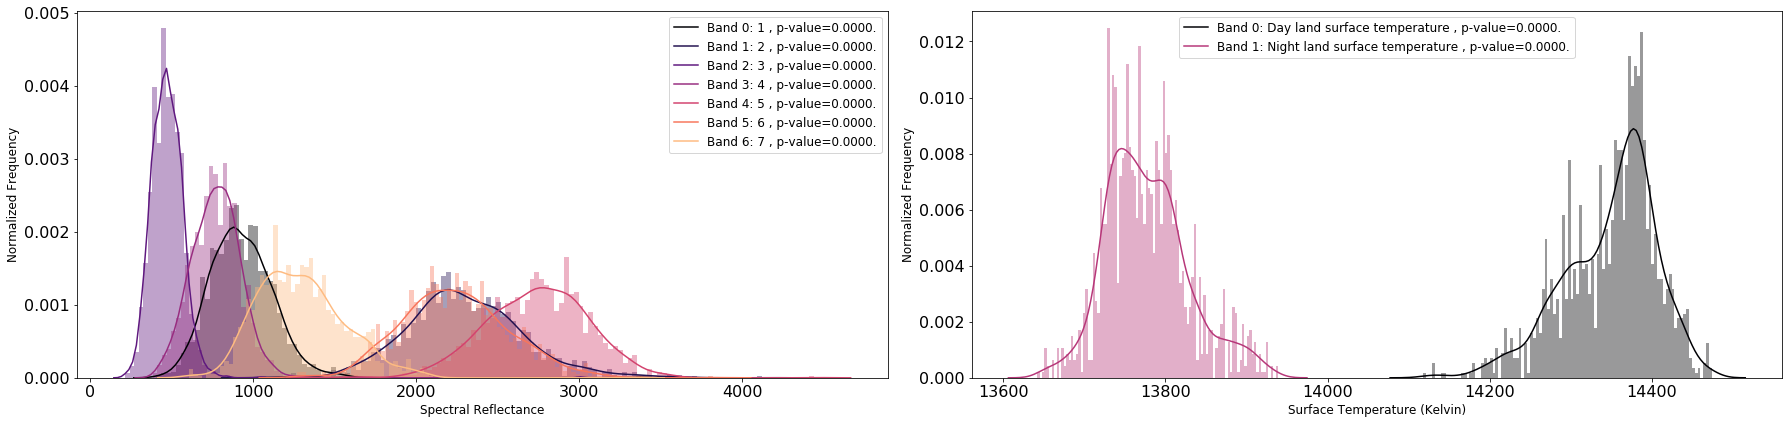

In [15]:
#ORIGINAL
# Plotting distribution of band values in 3000 images

plt_MODIS_LAND = plt_img_dist(os.path.join(output_path, 'MODIS_LAND'), 7, corn_grain)
plt_MODIS_TEMP = plt_img_dist(os.path.join(output_path, 'MODIS_TEMP'), 2, corn_grain)

cm = pylab.get_cmap('viridis')
band_name = {'MODIS_LAND': [1,2,3,4,5,6,7],
             'MODIS_TEMP': ['Day land surface temperature', 'Night land surface temperature']}
nbands = [7, 2]
plt_files = [plt_MODIS_LAND, plt_MODIS_TEMP]
xlabel = ['Spectral Reflectance', 'Surface Temperature (Kelvin)', 'Soil Moisture (mm)']

f, axs = plt.subplots(1, len(plt_files), figsize=(25,6))

for i, (name, plt_file) in enumerate(zip(band_name, plt_files)):
    cm = pylab.get_cmap('magma')
    
    for band in range(nbands[i]):
        color = cm(1.*band/nbands[i])
        _, p = normaltest(plt_file[band])
        sns.distplot(plt_file[band], color=color, ax=axs[i], bins=100, \
                     kde_kws={"label": 'Band {}: {} , p-value={:.4f}.'.format(band, band_name[name][band], p)})
        
    axs[i].set_xlabel(xlabel[i], fontsize=12)
    axs[i].set_ylabel('Normalized Frequency', fontsize=12)
    
plt.tight_layout()
plt.savefig('band distribution', dpi=500)
plt.show()

In [385]:
def get_stats(file_dir, nband, nsample, yield_dataframe):

    avg_MODIS_LAND = {band:[] for band in range(0, nband)}  # average per images (38 images per year for MODIS)
    std_MODIS_LAND = {band:[] for band in range(0, nband)}
    count_MODIS_LAND = {band:[] for band in range(0, nband)}

    avg_year = {band:[] for band in range(0, nband)}   # yearly average (for plotting)
    var_year = {band:[] for band in range(0, nband)}
    max_year = {band:[] for band in range(0, nband)}
    count_year = {band:[] for band in range(0, nband)}

    avg_total = {band:[] for band in range(0, nband)}     # Total average (for statistical analysis)
    std_total = {band:[] for band in range(0, nband)} 

    yield_ = []

    fips = yield_dataframe[['YEAR', 'STATE_FIPS', 'COUNTY_FIPS']][yield_dataframe['YEAR'] < 2018].values
    rand_idx = random.sample(range(0, len(fips)), nsample)

    for i in rand_idx:
        try:
            test = np.load(os.path.join(file_dir, str(fips[i][0]) + '_' + str(fips[i][1]) + '_' + str(fips[i][2]) + '.npy'))
            yield_ += [yield_dataframe['YIELD_BU_ACRE'][(yield_dataframe['STATE_FIPS'] == int(fips[i][1])) & (yield_dataframe['COUNTY_FIPS'] == int(fips[i][2])) \
                                          & (yield_dataframe['YEAR'] == int(fips[i][0]))].values]
            for band in range(nband):
                bands = list(np.arange(band, test.shape[2], nband)) 
                non_zero_index = test[:, :, bands].nonzero()
                count_year[band] += [len(non_zero_index[0])]
                avg_year[band] += [test[:, :, bands][non_zero_index].mean()]
                var_year[band] += [test[:, :, bands][non_zero_index].var()]
                max_year[band] += [test[:, :, bands].max()]

        except:
            pass

    for band in range(nband):
        # Delete NaN (i.e. samples that do not have any corn in that year)
        nan_idx = np.argwhere(np.isnan(avg_year[band]))
        avg_year[band] = np.delete(avg_year[band], nan_idx)
        var_year[band] = np.delete(var_year[band], nan_idx)
        count_year[band] = np.delete(count_year[band], nan_idx)


        avg_total[band] = np.sum(avg_year[band]*np.array(count_year[band]))/ np.sum(count_year[band])
        std_total[band] = np.sqrt(np.sum(var_year[band]*np.array(count_year[band]))/ np.sum(count_year[band]))

    yield_ = np.delete(yield_, nan_idx)       

    return avg_year, count_year, max_year, yield_, avg_total, std_total

In [386]:
path = os.path.join(output_path, 'MODIS_LAND')
avg_year_LAND, count_year_LAND, max_year_LAND, yield_LAND, avg_total_LAND, std_total_LAND = \
get_stats(path, 7, 500, corn_grain)

/home/james/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: Mean of empty slice.
/home/james/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/james/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: Degrees of freedom <= 0 for slice
/home/james/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/james/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [387]:
path = os.path.join(output_path, 'MODIS_TEMP')
avg_year_TEMP, count_year_TEMP, max_year_TEMP, yield_TEMP, avg_total_TEMP, std_total_TEMP =\
get_stats(path, 2, 500, corn_grain)

/home/james/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: Mean of empty slice.
/home/james/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: RuntimeWarning: Degrees of freedom <= 0 for slice


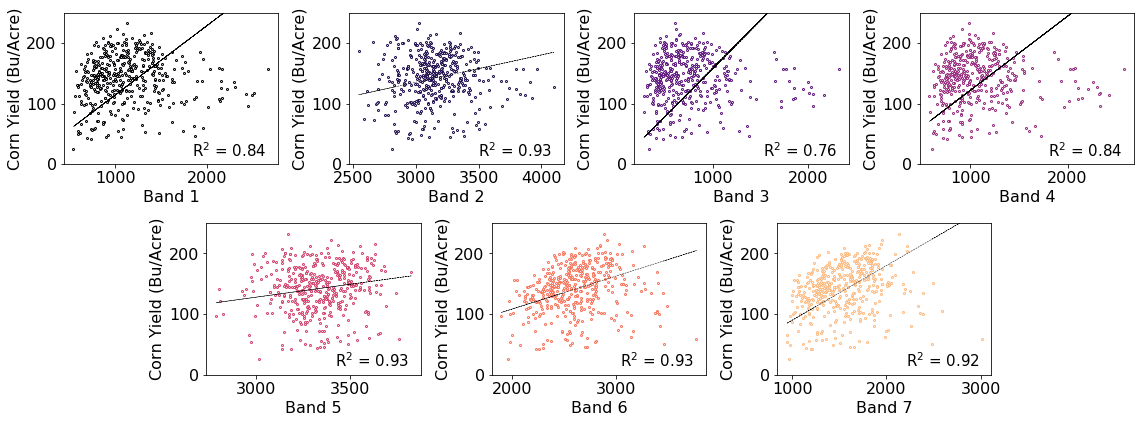

In [398]:
# Plotting correlations

fig = plt.figure(figsize=(16, 6))
gs = gridspec.GridSpec(nrows=2, ncols=16)

ax11 = fig.add_subplot(gs[0, :4])
ax21 = fig.add_subplot(gs[0, 4:8])
ax31 = fig.add_subplot(gs[0, 8:12])
ax41 = fig.add_subplot(gs[0, 12:16])
ax12 = fig.add_subplot(gs[1, 2:6])
ax22 = fig.add_subplot(gs[1, 6:10])
ax32 = fig.add_subplot(gs[1, 10:14])

axs = [ax11, ax21, ax31, ax41, ax12, ax22, ax32]
cm = pylab.get_cmap('magma')
nband = 7

for ax, band in zip(axs, avg_year_LAND):
    
    x = np.array(avg_year_LAND[band])
    y = np.array(yield_LAND)
    
    color = cm(1*band/nband)
    ax.scatter(x, y, color='white', edgecolors=color, s=4)
    ax.set_xlabel('Band ' + str(band + 1))
    ax.set_ylabel('Corn Yield (Bu/Acre)')
    
    # Generated linear fit
    results = sm.OLS(y, x).fit()
    line = results.params[0]*x
    ax.plot(x, line, '--', color='black',  linewidth=0.5)
    ax.annotate('R$^2$ = {:.2f}'.format(results.rsquared), xy=(0.6, 0.05), xycoords='axes fraction', fontsize=15)
    ax.set_ylim([0, 250])

fig.tight_layout()
plt.savefig('MODIS', dpi=500)
plt.show()

/home/james/anaconda3/lib/python3.7/site-packages/matplotlib/tight_layout.py:199: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  warnings.warn('Tight layout not applied. '


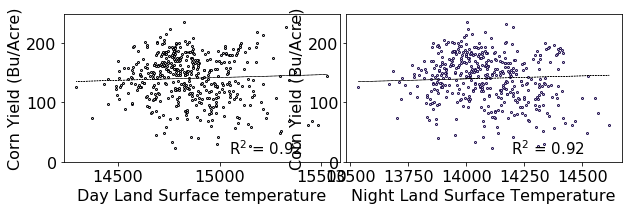

In [397]:
# Plotting correlations

fig = plt.figure(figsize=(10, 6))
gs = gridspec.GridSpec(nrows=2, ncols=16)

ax11 = fig.add_subplot(gs[0, :8])
ax21 = fig.add_subplot(gs[0, 8:16])
xlabel = ['Day Land Surface temperature', 'Night Land Surface Temperature']
axs = [ax11, ax21]
cm = pylab.get_cmap('magma')
nband = 7

for i, (ax, band) in enumerate(zip(axs, avg_year_TEMP)):
    
    x = np.array(avg_year_TEMP[band])
    y = np.array(yield_TEMP)
    # Delete NaN
    nan_idx = np.argwhere(np.isnan(x))
    x = np.delete(x, nan_idx)
    y = np.delete(y, nan_idx)
    
    color = cm(1*band/nband)
    ax.scatter(x, y, color='white', edgecolors=color, s=4)
    ax.set_xlabel(xlabel[i])
    ax.set_ylabel('Corn Yield (Bu/Acre)')
    
    # Generated linear fit
    results = sm.OLS(y, x).fit()
    line = results.params[0]*x
    ax.plot(x, line, '--', color='black',  linewidth=0.5)
    ax.annotate('R$^2$ = {:.2f}'.format(results.rsquared), xy=(0.6, 0.05), xycoords='axes fraction', fontsize=15)
    ax.set_ylim([0, 250])

fig.tight_layout()
plt.savefig('Temperature', dpi=500)
plt.show()

In [414]:
def create_input_3D(in_paths, fips, out_path):
    
    from tqdm import tqdm
    resolution = 128
    for fip in tqdm(fips):
        year = fip[0]
        state = fip[1]
        county = fip[2]

        img_1 = np.load(os.path.join(in_paths[0], '{}_{}_{}.npy'.format(year, state, county)))
        img_2 = np.load(os.path.join(in_paths[1], '{}_{}_{}.npy'.format(year, state, county)))

        bin_MODIS_LAND = get_bin(img_1, [[0, 4000]]*4 + [[0, 5000]]*2 + [[0, 4000]], 7, resolution)
        bin_MODIS_TEMP = get_bin(img_2, [[13500, 15250], [13000, 14250]], 2, resolution)

        bin_all = np.concatenate([bin_MODIS_LAND, bin_MODIS_TEMP], axis=0)

        np.save(os.path.join(out_path, '{}_{}_{}'.format(year, state, county)), bin_all)

In [ ]:
fips = corn_grain[['YEAR', 'STATE_FIPS', 'COUNTY_FIPS']][corn_grain['YEAR'] < 2017]
fips = fips[((fips['STATE_FIPS'] != 51) | (fips['COUNTY_FIPS'] != 131)) & \
           ((fips['STATE_FIPS'] != 46) | (fips['COUNTY_FIPS'] != 102))]
fips = fips[['YEAR', 'STATE_FIPS', 'COUNTY_FIPS']].values

pd.DataFrame(fips).to_csv(os.path.join(output_path, 'processed_fips.csv'))

create_input_3D([os.path.join(output_path, 'MODIS_LAND'), 
                os.path.join(output_path, 'MODIS_TEMP')
                ], fips, os.path.join(output_path, 'preprocessed_II'))

 36%|███▌      | 3353/9361 [16:40<32:29,  3.08it/s]  

In [ ]:
# Originally we output the processed input as (nband, resolution, frame per year) per file (11077) files
# I just realized that previous shaping was wrong and here we are reshaping it to (frames, 1, resolution, nband)

nband = 11
resolution = 128

for file_name in tqdm(glob.glob('data\PROCESSED/*.npy')):
    year, state, county = file_name[15:-4].split('_')
    processed_img = np.load(file_name)
    output_name = ('_').join([year, state, county])
    
    frames = processed_img.shape[2]
    new_processed_img = np.zeros((frames, 1, resolution, nband))
    for frame in range(frames):
        for band in range(nband):
            new_processed_img[frame, :, :, band] = processed_img[band, :, frame]
    np.save('data/PROCESSED_II/' + output_name + '.npy', new_processed_img)

In [ ]:
# The previous preprocessing we forgot that the mask from satellites can cause some images become all zeros
# although the USDA data says it has yields. This discrepancy cause the image to be nan during the binning process.

count_nonnan = 0
removed_ID = []
for filename in tqdm(glob.glob('data/PROCESSED_II/*.npy')):
    file = np.load(filename)
    if np.sum(np.isnan(file)) == 0:
        np.save('data/PROCESSED_III/' + filename[18:-4] + '.npy', file)
        count_nonnan += 1
    else:
        removed_ID += [filename[18:-4]]
print('The number of processed files with no nan is {} from the original of {}.'.format(count_nonnan, len(glob.glob('data/PROCESSED_II/*.npy'))))
#pickle.dump(removed_ID, open("data/removed_ID.p", "wb" ) )

In [ ]:
# Preparing {county_year:yield} dictionary data for model evaluation

# Load fips and other data
fips = pd.DataFrame(pd.read_csv('data/processed_fips.csv').drop(['Unnamed: 0'], axis=1))
corn_grain = pd.read_csv('data/corn_grain.csv').drop(['Unnamed: 0'], axis=1)
fips_yields = corn_grain.merge(fips)[['YEAR', 'STATE_FIPS', 'COUNTY_FIPS', 'YIELD']].astype(str)
fips_yields['YIELD'] = fips_yields['YIELD'].astype(float)
fips_yields['ID'] = fips_yields.apply(lambda row: row['YEAR'] + '_' + row['STATE_FIPS'] + \
                                      '_' + row['COUNTY_FIPS'], axis=1)
# Remove the IDs with Nans
removed_ID = pd.DataFrame(removed_ID, columns=['ID'])
fips_yields = fips_yields[~fips_yields['ID'].isin([i[0] for i in removed_ID.values.tolist()])]

fips_yields = fips_yields.set_index('ID')
display(fips_yields.head())

print('\n' + '#'*13, 'YIELD MAPPING', '#'*13)

yields_train = fips_yields[['YIELD']][fips_yields['YEAR'] != '2016'].to_dict()['YIELD'] # data from year 2010-2015
yields_test = fips_yields[['YIELD']][fips_yields['YEAR'] == '2016'].to_dict()['YIELD'] # data form year 2016

keys = ['train', 'validation']
values = [yields_train, yields_test]
yields = {key:value for key, value in zip(keys, values)}

for key in list(yields['train'].keys())[0:5]:
    print(key, '=',  yields['train'][key])
print('#'*41)
#pickle.dump(yields, open("data/yields.p", "wb" ) )